Note Description:

Dynamic Time Warping (DTW) is applied to measure the similarity between time series. Time series of landscape units were compared with reference time series.

dtw package: https://pypi.org/project/dtw-python/ </br>

`pip install dtw-python`

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import glob
from tqdm.notebook import tqdm

import geopandas as gpd

from dtw import dtw

import plotly.express as px
import plotly.graph_objects as go

# Load Data

In [3]:
df_ts = pd.read_csv('data/vh_2022.csv', index_col=0)
df_ref = pd.read_csv('data/vh_ref_2022.csv', index_col=0)

# Dynamic Time Warping

Select time series of landscape units that share similar temporal pattern with a given reference time series.

In [4]:
def calculate_dtw(ts_blk, ts_ref, window_size=5):

    def interpolate_time_series(ts_blk, intv):

        nrow, ncol = ts_blk.shape
        mat = np.zeros([nrow, ncol * intv]) * np.nan
        mat[:, ::intv] = ts_blk

        df = pd.DataFrame(mat)
        df.interpolate(method='linear', axis=1, inplace=True)
        ts_blk_intp = df.values[:, :-(intv-1)]
        return ts_blk_intp
    
    ts_ref = ts_ref[np.newaxis, :]
    
    # increase the resolution of the time series by interpolation
    ts_blk = interpolate_time_series(ts_blk, intv=4)
    ts_ref = interpolate_time_series(ts_ref, intv=4)

    n = ts_blk.shape[0]
    d = np.zeros(n) * np.nan
    for i in range(n):
        alignment = dtw(
            ts_ref,
            ts_blk[i, :],
            keep_internals=True,
            window_type= "sakoechiba",
            window_args= {"window_size": window_size},
        )
        d[i] = alignment.distance
    return d

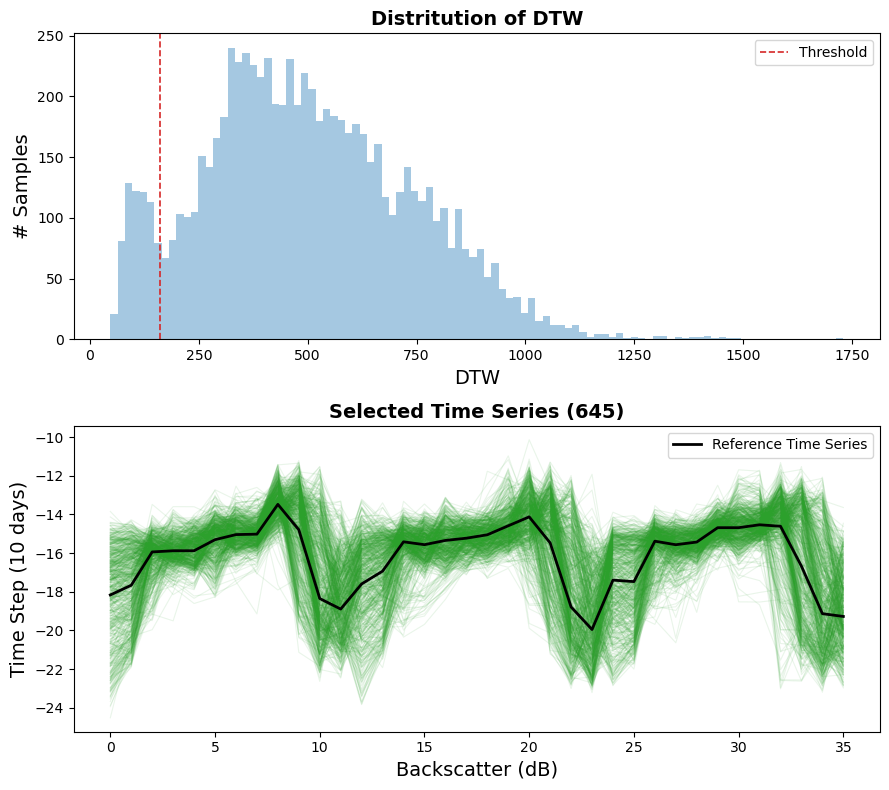

In [5]:
ts_blk = df_ts.values
ts_ref = df_ref.loc['Class 01'].values

d = calculate_dtw(ts_blk, ts_ref, 7)

thr = 160
idx = d < thr

# idx = d.argsort()[:600]
# thr = d[idx[-1]]

df_ts_sel = df_ts.iloc[idx, :]
n_sel = df_ts_sel.shape[0]

fig, axes = plt.subplots(2, 1, figsize=[9, 8])

axes[0].hist(d, bins=100, alpha=.4);
axes[0].axvline(thr, color='tab:red', linestyle='--', lw=1.2, label='Threshold');
axes[0].set_xlabel('DTW', fontsize=14);
axes[0].set_ylabel('# Samples', fontsize=14);
axes[0].set_title('Distritution of DTW', fontsize=14, fontweight='bold');
axes[0].legend();

axes[1].plot(df_ts_sel.values.T, color='tab:green', lw=.8, alpha=.1);
axes[1].plot(ts_ref, color='k', lw=2, label='Reference Time Series');
axes[1].set_xlabel('Backscatter (dB)', fontsize=14);
axes[1].set_ylabel('Time Step (10 days)', fontsize=14);
axes[1].set_title(f'Selected Time Series ({n_sel})', fontsize=14, fontweight='bold');
axes[1].legend();

fig.tight_layout()